In [1]:
%env CUDA_VISIBLE_DEVICES=0
import torch as ch
import itertools
from torch import nn
import torch.nn.functional as F
import numpy as np
from mnist_config import trainloader, testloader
import matplotlib.pyplot as plt
from models.encoders import MNISTAutoEncoder
from models.simple_models import SmallSimpleClassifier, MNISTClassifier
from optim import OAdam

env: CUDA_VISIBLE_DEVICES=0


In [2]:
net = MNISTClassifier().cuda()
net.load_state_dict(ch.load('./results/trained_net_l2_madry_mnist_1.5'))

ae = MNISTAutoEncoder(784, 128,spectral_norm=False).cuda()
ae.load_state_dict(ch.load('./final_4_retuned_6_ae'))

ae.eval()
net.eval()

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc): Linear(in_features=3136, out_features=1024, bias=True)
  (final_fc): Linear(in_features=1024, out_features=10, bias=True)
)

In [3]:
total_error = 0.
total = 0.
num_attacks = 0.
for original, labels in testloader:
    original = original.cuda()
    labels = labels.cuda()
    norm = ch.norm((original-ae(original)).view(original.shape[0],-1),dim=-1)
    total_error += norm.sum().item()
    total += original.shape[0]

    batch_size = testloader.batch_size
    im = original[:batch_size,:,:,:].view(batch_size,1,28,28)
    EPS = 1.5 
    ones = ch.ones(batch_size,1).cuda()

    z_ = ae.encode(im).detach().cuda()
    z_.requires_grad = False

    z = z_.detach()# + 1e-3*ch.randn(z_.shape).cuda()
    z.requires_grad = True

    lambda_ = 1e-2*ch.rand(batch_size,1).cuda()
    lambda_.requires_grad = True

    opt1 = OAdam([{'params':z}], lr=5e-3)
    opt2 = OAdam([{'params':lambda_}], lr=1e-4)
    # opt1 = OAdam([{'params':z}], lr=1e-4)
    # opt2 = OAdam([{'params':lambda_}], lr=1e-4)# num_steps = 120, ratio = 1


    softmax = nn.Softmax()
    ce = nn.CrossEntropyLoss(reduction='mean')

    ref = ae(im).detach() #im

    for i in range(3):
        opt1.zero_grad()
    #     ae_error = ch.norm((im-ae(im)).view(batch_size,-1),dim=-1)
    #     ce_error = ce(net(ae.decode(z)),net(ref).detach().argmax(1))
    #     constraint_error = ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1) - EPS*ones
        # triangle inequality version
    #     constraint_error = ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1) - (EPS*ones - ae_error)

    #     loss1 =  -ce_error + ch.mean(lambda_ * constraint_error)
        loss1 = -1.* ce(net(ae.decode(z)),net(ref).detach().argmax(1)) + \
        ch.mean(lambda_ * (ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1,keepdim=True) - EPS*ones))
        loss1.backward(retain_graph=True)
        opt1.step()
        z.clamp(-1,1)
        for j in range(1):
            opt2.zero_grad()
            loss2 = -1.*ch.mean(lambda_ * (ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1,keepdim=True) - EPS*ones)) #ch.mean(lambda_ * constraint_error)
            loss2.backward(retain_graph=True)
            opt2.step()
            lambda_ = lambda_.clamp(1e-3,1e5)

    norm = ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1)
    valid = (norm < EPS).float()
    pred1 = net(ref).argmax(1)
    pred2 = net(ae.decode(z)).argmax(1)
    count = ((pred1!=pred2).float() * valid).sum()
#         print(count.item(),norm)
    num_attacks += count.item()


In [4]:
print("Number of successful attacks: %d" %(num_attacks))

Number of successful attacks: 2543


# Print indices of successful attacks

In [5]:
norm = ch.norm((ref-ae.decode(z)).view(batch_size,-1),dim=-1)
valid = (norm < 1.5).float()
pred1 = net(ref).argmax(1)
pred2 = net(ae.decode(z)).argmax(1)
    
success = ((pred1!=pred2).float() * valid)

xx = np.where(success.detach().cpu().numpy() > 0)[0]
print(xx)
if xx.shape[0] >0:
    idx = xx[0]

[ 4  9 10 20 22 25 27 32 35 37 47]


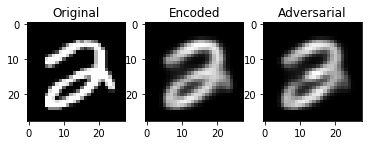

In [6]:
fig = plt.figure()
plt.subplot(131)
plt.imshow(im[idx].detach().cpu().numpy().reshape(28,28),cmap='gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(ae(im)[idx].detach().cpu().numpy().reshape(28,28),cmap='gray')
plt.title('Encoded')
# plt.show()
plt.subplot(133)
plt.imshow(ae.decode(z)[idx].detach().cpu().numpy().reshape(28,28),cmap='gray')
plt.title('Adversarial')
# plt.show()
plt.savefig('attack.png')